# Market-implied stock price PDFs: risk-neutral and physical

Option prices embed information about the markets expectation of future performance of the underlying asset.
The set of European option prices across strikes for a given maturity $T$ implies a risk-neutral probability density function (details below) of the price $S_T$ of the underlying asset at the maturity.

This density reflects the distribution consistent with current option prices under the pricing measure that discounts payoffs at the risk-free rate.
It also reflects both how the market expects the underlying to move (although it is important to note that the pdf we obtain is NOT simply the market's prediction of where the stock is likely to move), as well as how the market prices risk across the various outcomes.

This project uses several years of daily SPX option chain data to extract the market-implied risk-neutral pdfs for options with 1 day maturities, 7 day maturities, and 28 day maturities.
Using the Breeden-Litzenberger relation, which says that the implied pdf is given by the second partial derivative of price at maturity with respect to strike:
$$ f_Q(K) = e^{rT} \frac{\partial^2 C(K, T)}{\partial K^2},$$
we numerically recover the pdf.
Since strikes come in discrete increments, we require some numerical techniques to interpolate.
We also need to smooth the data enough to take a second derivative.

I then discuss and compare ways of recovering the real-world probability distribution from the risk-neutral one.

There are two main goals of this project:
1. Compare the risk-neutral pdf to the realized price distribution.
2. Test a simple way of estimating the real-world density function from the risk-neutral density.

The secondary goal is to give exposition of the theory and background needed to understand this topic so that a wider audience may find it useful and engaging.


## Part 1: Implied risk-neutral distributions

### Theoretical Background

#### **Risk-neutral probability measure**

We start with almost the simplest possible case: a market that will evolve over only one timestep.
Time $t=0$ is the starting point, and time $t=1$ is the final step in the evolution of the market.
At $t=1$, the world can be in one of $n$ possible states
$$ \Omega = \{\omega_1, \dots, \omega_n\}$$
with real-world probabilities $P(\omega_i) \geq 0$, $\sum_i P(\omega_i) = 1$.

Suppose our market has one traded asset $S$, worth $\$100$ at $t=0$ and a risk-free account with interest rate $r$.
Suppose also that for some set $U \subset \Omega$ of states of the world at $t=1$, $S$ will go up to $S_0 \cdot u$, and for the complement $D = \Omega \setminus U$, $S$ will go down to $S_0 \cdot d$, for some factors $u,d$ with $0 < d < 1 < u$.

There is some real-world probability $P(U)$ that $S$ will go up, and some real probability $P(D)$ that $S$ will go down.
These probabilities are of course unknowable, but it turns out that they are not necessary for the risk-neutral probability measure.

Now if $e^r < d$, then there is an arbitrage scheme: borrow $S_0$ dollars at $t=0$ and buy one unit of $S$.
Then regardless of whether the asset goes up or down, the value at $t=1$ would be higher than $S_0 e^r$, which is the amount one would owe at the end.

Similarly, if $e^r > u$, one could short the stock and invest the proceeds into the risk-free account, and have a guaranteed profit.

The *no-arbitrage condition* $u \leq e^r \leq u$ ensures that there is no arbitrage in this simple model.
These inequalities also imply the following bounds:
$$
\begin{align*}
0 &\leq \frac{e^r - d}{u - d} \leq 1 \\
0 &\leq \frac{u - e^r}{u - d} \leq 1.
\end{align*}
$$
Note also that
$$
\frac{e^r - d}{u - d} + \frac{u - e^r}{u - d} = 1.
$$
Now if we assign $Q(U) = \frac{e^r - d}{u - d}$, and $Q(D) = \frac{u - e^r}{u - d}$, then $Q$ defines a probability measure on $\{\varnothing, U, D, \Omega \} \subset \mathcal P(\Omega)$.
This is the risk-neutral probability measure for this toy model, which we have just derived without any reference to the real-world probabilities of any events occurring.

Moreover, it is not too hard to calculate (see [here](https://quant.stackexchange.com/questions/55239/explaining-the-risk-neutral-measure), for example) that $S_0 = e^{-r} \mathbb E[S_1]$.

The dynamics of the real market are of course more complicated, but the idea of the risk-neutral probability measure is the same:
it is the probability measure under which all (discounted) tradable asset prices are martingales.


#### **The Breeden-Litzenberger Formula**
Recall that the fair value of a call option with time $\tau$ until expiry is the present value of the expected payoff.
If $f_Q$ denotes the PDF of the stock prices $S_T$ of some stock $S$ at time $T$ (with respect to the risk-neutral measure $Q$), this is
$$
\begin{align*}
C(K, \tau) &= e^{-rt} \mathbb E_Q(\max\{S_T - K, 0\}) \\
&= e^{-rt} \int_0^\infty \max\{x - K, 0\} f_Q(x) \, d x \\
&= e^{-rt} \int_K^\infty (x - K) f(x) \, dx.
\end{align*}
$$
To derive the Breeden-Litzenberger formula, we just need to invert this to find $f$ as a function of $C$.
Taking the partial derivative with respect to $K$ gives
$$
\begin{align*}
\frac{\partial C}{\partial K} &= - e^{-rt} \int_{K}^\infty f(x) \, dx \\
&= e^{-rt} \left( \int_{-\infty}^K f(x) \, dx - 1 \right),
\end{align*}
$$
where in the second step we use the fact that $\int_{\R} f(x) \, dx = 1$.
But now we can find $f$ by taking one more derivative.
Doing this and rearranging, we see that
$$f(K) = e^{rt} \frac{\partial^2 C}{\partial K^2}.$$

### Implementation

The first thing we'll do is use the Breeden-Litzenberger formula to computed market-implied risk-neutral probability densities.

#### The data

I obtained my options chain data from OptionsDX.
I have EOD options chain data for SPX for years 2020 through 2023.
I filtered for options with 1 day maturities, 7 day maturities, and 28 day maturities, so that I can compare all the methods across a range of expiration lengths.
See `processing.ipynb` in the `data` directory for the code and more explanation of data preprocessing.

First I'll import the data and get it into the dataframes that I want.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import random
from black_scholes import *     # utility functions related to the Black-Scholes formula

from scipy.interpolate import CubicSpline # for cubic interpolation with smoothing
from scipy.interpolate import make_splrep

In [2]:
data_years = ["2020", "2021", "2022", "2023"]

spx_dfs = [
    pd.read_csv(f"data/spx_options_{year}.csv")
    for year in data_years
]

spx_df = pd.concat(spx_dfs, ignore_index=True).dropna()



numeric_cols = ['call_iv', 'call_last', 'put_last'] # TODO: and some more
for col in numeric_cols:
    spx_df[col] = pd.to_numeric(spx_df[col], errors="coerce")

print("This datatframe contains all the data that we'll use for this project.")
display(spx_df)

spx_1dte = spx_df[spx_df['tte_unix'] == 60*60*24]
spx_7dte = spx_df[spx_df['tte_unix'] == 60*60*24*7]
spx_28dte = spx_df[spx_df['tte_unix'] == 60*60*24*28]

# create a collection of dataframes, one for each day
spx_1dte_dfs = [
    spx_1dte[spx_1dte['quote_unix'] == utime]
    for utime in spx_1dte['quote_unix'].unique()
]

spx_7dte_dfs = [
    spx_7dte[spx_7dte['quote_unix'] == utime]
    for utime in spx_7dte['quote_unix'].unique()
]

spx_28dte_dfs = [
    spx_28dte[spx_28dte['quote_unix'] == utime]
    for utime in spx_28dte['quote_unix'].unique()
]

print("This dataframe corresponds to all the options on a given day with a given expiry date.")
display(spx_1dte_dfs[0])

This datatframe contains all the data that we'll use for this project.


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,tte_years,call_mid,put_mid
0,3002.74,1583355600,1583269200,2020-03-03 16:00:00,1800.0,4.69707,1200.81,1210.10,1210.60,2.00098,0.0,0.05,0.10,1.0,86400,0.002740,1205.455,0.025
2,3002.74,1583355600,1583269200,2020-03-03 16:00:00,1950.0,3.83174,1050.80,1060.11,0.00,1.70212,0.0,0.05,0.00,1.0,86400,0.002740,1055.455,0.025
5,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2100.0,3.09885,900.90,910.31,0.00,1.42364,0.0,0.05,0.05,1.0,86400,0.002740,905.605,0.025
9,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2300.0,2.26013,700.80,710.10,718.60,1.07846,0.0,0.04,0.15,1.0,86400,0.002740,705.450,0.020
13,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2450.0,1.74473,550.70,560.90,0.00,0.83460,0.0,0.05,0.05,1.0,86400,0.002740,555.800,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373997,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4275.0,0.13586,14.30,14.60,9.24,0.12984,167.9,170.50,295.83,28.0,2419200,0.076712,14.450,169.200
373998,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4280.0,0.13573,13.60,13.80,8.64,0.11912,170.7,172.50,0.00,28.0,2419200,0.076712,13.700,171.600
373999,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4285.0,0.13550,12.60,12.90,10.25,0.11255,174.6,176.50,202.50,28.0,2419200,0.076712,12.750,175.550
374000,4109.88,1682712000,1680292800,2023-03-31 16:00:00,4290.0,0.13485,11.80,12.00,3.87,0.12305,180.2,182.90,345.00,28.0,2419200,0.076712,11.900,181.550


This dataframe corresponds to all the options on a given day with a given expiry date.


,underlying_last,expire_unix,quote_unix,quote_time,strike,call_iv,call_bid,call_ask,call_last,put_iv,put_bid,put_ask,put_last,dte,tte_unix,tte_years,call_mid,put_mid
0,3002.74,1583355600,1583269200,2020-03-03 16:00:00,1800.0,4.69707,1200.81,1210.10,1210.6,2.00098,0.00,0.05,0.10,1.0,86400,0.00274,1205.455,0.025
2,3002.74,1583355600,1583269200,2020-03-03 16:00:00,1950.0,3.83174,1050.80,1060.11,0.0,1.70212,0.00,0.05,0.00,1.0,86400,0.00274,1055.455,0.025
5,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2100.0,3.09885,900.90,910.31,0.0,1.42364,0.00,0.05,0.05,1.0,86400,0.00274,905.605,0.025
9,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2300.0,2.26013,700.80,710.10,718.6,1.07846,0.00,0.04,0.15,1.0,86400,0.00274,705.450,0.020
13,3002.74,1583355600,1583269200,2020-03-03 16:00:00,2450.0,1.74473,550.70,560.90,0.0,0.83460,0.00,0.05,0.05,1.0,86400,0.00274,555.800,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,3002.74,1583355600,1583269200,2020-03-03 16:00:00,3580.0,0.77584,0.00,0.11,0.1,0.00152,572.40,582.60,0.00,1.0,86400,0.00274,0.055,577.500
216,3002.74,1583355600,1583269200,2020-03-03 16:00:00,3610.0,0.80864,0.00,0.09,0.0,0.00109,603.89,614.10,0.00,1.0,86400,0.00274,0.045,608.995
219,3002.74,1583355600,1583269200,2020-03-03 16:00:00,3650.0,0.85353,0.00,0.10,0.0,0.00144,644.90,655.10,0.00,1.0,86400,0.00274,0.050,650.000
220,3002.74,1583355600,1583269200,2020-03-03 16:00:00,3675.0,0.87987,0.00,0.10,0.0,0.00168,669.90,680.10,0.00,1.0,86400,0.00274,0.050,675.000


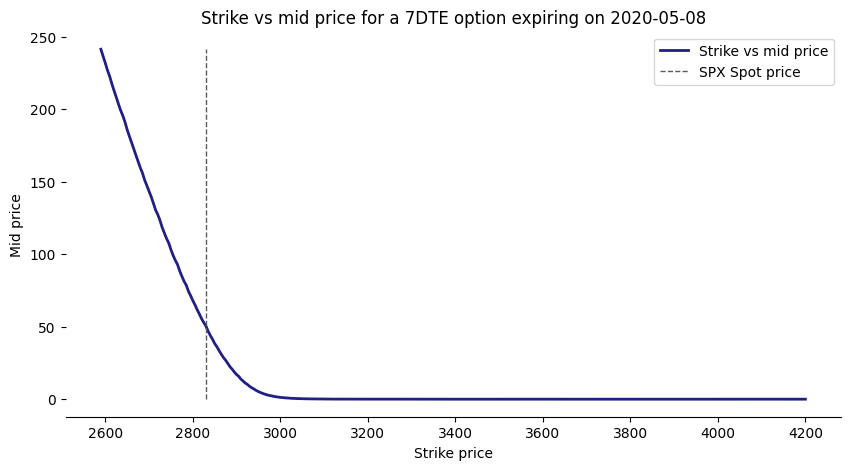

In [3]:
fig, ax = plt.subplots(figsize=(10,5))

# pick a random option chain to display (from the 7dte options)
df = spx_7dte_dfs[random.randint(0,len(spx_7dte_dfs)-1)].copy()
expire_date = pd.to_datetime(df['expire_unix'].mode()[0], unit="s").date()
plt.title(f"Strike vs mid price for a 7DTE option expiring on {expire_date}")

ax.plot(df['strike'], df['call_mid'], color="#1F1F84", linewidth=2, label=f"Strike vs mid price")
ax.vlines(df['underlying_last'].mean(), ymin=0, ymax=df['call_mid'].max(), color="#5C5C5C", linestyle="--", linewidth=1, label="SPX Spot price")

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xlabel("Strike price")
ax.set_ylabel("Mid price");
ax.legend();


Since the scale of this plot is large, this curve may appear smooth even when it contains small irregularities.
Extracting the implied probability density requires computing second derivatives, which will amplify any irregularities.
Due to this, we need to smooth this curve.
Also due to this, we should not try interpolating/smoothing directly on this data; the second derivative will be highly unstable.

A more robust approach is to convert the prices to implied volatilities using Black-Scholes, perform the interpolation in volatility space, and then convert back to prices.
In fact, we'll do one more step: after we obtain implied volatility as a function of strike price, we'll convert it to a function of log-moneyness (roughly, this is just the log of the strike price), *then* do the smoothing, and then convert back.

The example below illustrates the problem with trying to smooth prices directly (it's possible that the graphs below don't look that bad; if so just run the cell above and then the one below again and it will almost certainly illustrate the problem clearly).


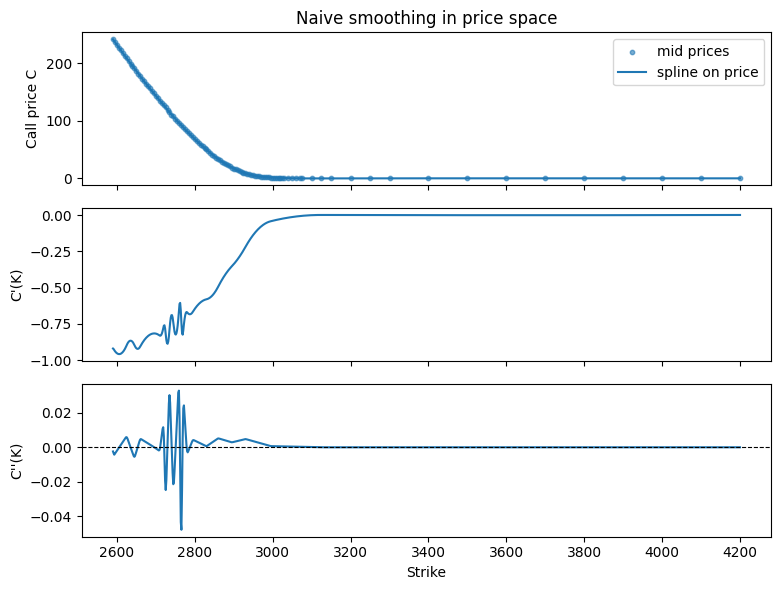

In [4]:
K = np.asarray(df["strike"])
C_mid = np.asarray(df["call_mid"])

mask = np.isfinite(K) & np.isfinite(C_mid)
K = K[mask]
C_mid = C_mid[mask]

order = np.argsort(K)
K = K[order]
C_mid = C_mid[order]

smoothing = 0.035 * len(K)

price_spline = make_splrep(K, C_mid, k=3, s=smoothing)

K_fine = np.linspace(K.min(), K.max(), 1000)
C_smooth = price_spline(K_fine)

dC_dK = np.gradient(C_smooth, K_fine)
d2C_dK2 = np.gradient(dC_dK, K_fine)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axes[0].scatter(K, C_mid, s=10, alpha=0.6, label="mid prices")
axes[0].plot(K_fine, C_smooth, label="spline on price", linewidth=1.5)
axes[0].set_ylabel("Call price C")
axes[0].legend()
axes[0].set_title("Naive smoothing in price space")

axes[1].plot(K_fine, dC_dK, linewidth=1.5)
axes[1].set_ylabel("C'(K)")

axes[2].plot(K_fine, d2C_dK2, linewidth=1.5)
axes[2].axhline(0.0, color="black", linestyle="--", linewidth=0.8)
axes[2].set_ylabel("C''(K)")
axes[2].set_xlabel("Strike")

plt.tight_layout()
plt.show()


In the following cell, we define functions that convert the price data to implied volatility, perform a smoothed interpolation, convert back to price, and then compute the second derivative.

In [ ]:
from scipy.interpolate import make_splrep, interp1d

def compute_implied_vols(strikes, prices, spot, T, option_type, r=0.0):
    """
    Apply the Black-Scholes formula to the given arrays of strikes and option prices.
    Return the strikes and the corresponding implied volatilities.
    """
    strikes = np.asarray(strikes)
    prices = np.asarray(prices)

    iv_list = []
    strikes_list = []

    for k, c in zip(strikes, prices):
        try:
            iv = bs_implied_volatility(
                option_type=option_type,
                market_price=c,
                S0=spot,
                K=k,
                t=T,
                r=r,
            )
        except Exception:
            continue

        if iv is None or not np.isfinite(iv):
            continue

        strikes_list.append(k)
        iv_list.append(iv)

    strikes_valid = np.array(strikes_list)
    iv_valid = np.array(iv_list)

    order = np.argsort(strikes_valid)
    return strikes_valid[order], iv_valid[order]

def fit_iv_logmoneyness(strikes, iv, forward, smoothing_factor=None):
    """
    Fit a smooth implied volatility curve σ(K) as a function of log-moneyness.

    The function transforms strikes to log-moneyness coordinates
        lm = log(K / F)
    where F is the forward price, and fits a cubic smoothing spline
    to log(σ(lm)) rather than σ(lm) directly. This guarantees positive
    volatility values after exponentiation and yields a smooth, stable curve.

    Parameters
    ----------
    strikes : array-like
        Strike prices at which implied volatilities are observed.
    iv : array-like
        Observed implied volatilities (in decimals, not percentages)
        corresponding to `strikes`.
    forward : float
        Forward price of the underlying asset, typically computed as
        `F = S * exp(r * T)`.
    smoothing_factor : float, optional
        Spline smoothing parameter passed to `scipy.interpolate.make_splrep`.
        Larger values produce a smoother curve at the cost of fidelity to data.
        If None, a small default proportional to the number of data points
        (0.01 * n) is used.

    Returns
    -------
    iv_of_strike : callable
        Function mapping a strike `K` to its smoothed implied volatility.
        This function evaluates the spline in log-moneyness space internally.
    K_grid : ndarray
        Uniformly spaced grid of strike values spanning the fitted domain.

    Notes
    -----
    - Fitting in log-moneyness space provides better numerical stability and
      more natural curvature around the at-the-money region.
    - The spline is fit to log(σ) to enforce strictly positive volatilities.
    - The resulting curve is smooth and differentiable, suitable for subsequent
      computation of option prices and risk-neutral densities.
    """
    strikes = np.asarray(strikes)
    iv = np.asarray(iv)

    lm_vals = np.log(strikes/forward)

    iv = np.maximum(iv, 1e-4)
    log_iv = np.log(iv)

    # sort by lm for a well-behaved spline
    order = np.argsort(lm_vals)
    lm_sorted = lm_vals[order]
    log_iv_sorted = log_iv[order]
    strikes_sorted = strikes[order]

    if smoothing_factor is None:
        n = len(lm_vals)
        smoothing_factor = 0.05 * n

    # spline in log-moneyness space
    spline_log_iv = make_splrep(
        lm_sorted,
        log_iv_sorted,
        k=3,
        s=smoothing_factor,
    )

    # create a function of strike rather than log-moneyness
    def iv_of_strike(K):
        K = np.asarray(K)
        lm = np.log(K / forward)
        log_iv_val = spline_log_iv(lm)      # spline is defined in lm-space
        return np.exp(log_iv_val)     

    K_grid = np.linspace(strikes_sorted.min(), strikes_sorted.max(), 500)

    return iv_of_strike, K_grid
    

def smooth_option_curve(strikes, option_prices, spot, T, option_type, r=0, forward=None, n_grid=500, smoothing_factor=None):
    """
    Construct a smooth option price curve as a function of strike by
    interpolating and smoothing the implied volatility surface.

    This function performs the following sequence:
        1. Sorts and linearly interpolates the raw option prices across strikes
           to fill in missing or unevenly spaced data.
        2. Computes implied volatilities at each (interpolated) strike.
        3. Fits a smooth implied volatility function σ(K) in log-moneyness space.
        4. Converts the smoothed implied volatility curve back into
           option prices using the Black–Scholes model.

    Parameters
    ----------
    strikes : array-like
        Array of strike prices corresponding to observed option prices.
    option_prices : array-like
        Array of option mid prices (call or put) corresponding to `strikes`.
    spot : float
        Current spot price of the underlying asset.
    T : float
        Time to expiration in years.
    option_type : {'call', 'put'}
        Type of option to process.
    r : float, optional
        Risk-free rate used for discounting. Default is 0.
    forward : float, optional
        Forward price of the underlying. If None, computed as
        `spot * exp(r * T)`.
    n_grid : int, optional
        Number of points to evaluate in the smoothed grid.
        (Currently unused if using log-moneyness smoothing.)
    smoothing_factor : float, optional
        Spline smoothing parameter controlling the degree of smoothness
        in the implied volatility fit. If None, a small default is chosen
        automatically.

    Returns
    -------
    strike_grid : ndarray
        Array of strike prices corresponding to the smoothed curve.
    price_smooth : ndarray
        Array of option prices implied by the smoothed IV curve.
    iv_of_strike : callable
        Function mapping a strike price `K` to its fitted implied volatility.

    Notes
    -----
    - Linear interpolation is used to fill gaps in the (strike, price) data,
      assuming near-linearity of prices away from the money.
    - The smoothing step is done in *log-moneyness* space to ensure
      stability of numerical differentiation when later constructing PDFs.
    - The output price curve is smooth and differentiable, suitable for
      applying the Breeden–Litzenberger method to extract implied densities.
    """
    strikes = np.asarray(strikes)
    option_prices = np.asarray(option_prices)

    # in a few dataframes there are large gaps in the (strikes, option_prices) curve
    # I think linear interpolation should be fine to fill these in
    # the point is that away from the spot price the graph is basically linear,
    # and this process should be stable under perturbations in price space anyway

    order = np.argsort(strikes)
    strikes = strikes[order]
    option_prices = option_prices[order]

    diffs = np.diff(strikes)
    typical_step = np.median(diffs)

    # Define a uniform strike grid between min and max
    strike_fine = np.arange(strikes.min(), strikes.max() + typical_step, typical_step)

    # linearly interpolate option prices
    interp_func = interp1d(strikes, option_prices, kind='linear', fill_value="extrapolate")
    option_prices_interp = interp_func(strike_fine)

    strikes = strike_fine
    option_prices = option_prices_interp
 
    # calculate iv on observed strikes (not exactly observed anymore since we interpolated)
    strikes_obs, iv_obs = compute_implied_vols(
        strikes=strikes,
        prices=option_prices,
        spot=spot,
        T=T,
        option_type=option_type,
        r=r,
    )

    if forward is None:
        forward = spot * np.exp(r * T)

    # fit IV(lm)
    iv_of_strike, strike_grid = fit_iv_logmoneyness(
        strikes=strikes_obs,
        iv=iv_obs,
        forward=forward,
        smoothing_factor=smoothing_factor
    )

    # convert back to prices via Black–Scholes
    iv_on_grid = iv_of_strike(strike_grid)

    price_smooth = np.array([
        bs_price(
            S0=spot,
            K=strike_grid[i],
            sigma=iv_on_grid[i],
            t=T,
            r=r,
            option_type=option_type,
        )
        for i in range(len(strike_grid))
    ])
    
    
    return strike_grid, price_smooth, iv_of_strike

def create_pdf_from_df(df: pd.DataFrame, option_type):

    strike_grid, price_smooth, iv_of_strike = smooth_option_curve(
        strikes = df['strike'],
        option_prices = df[f'{option_type}_mid'],
        spot = df['underlying_last'].mean(), # this column should be constant but we'll take the mean anyway
        T = df['tte_years'].iloc[0],
        option_type = option_type,
    )
    
    f = np.gradient(price_smooth, strike_grid)
    f_2 = np.gradient(f, strike_grid)


    # ensure nonnegative and normalize
    f_2 = np.clip(f_2, 0, None)
    area = np.trapezoid(f_2, strike_grid)
    if area > 0:
        f_2 /= area

    return strike_grid, price_smooth, CubicSpline(strike_grid, f_2)

Now we can demonstrate the method in a few applications.
We'll pick a few random days and construct the pdf.

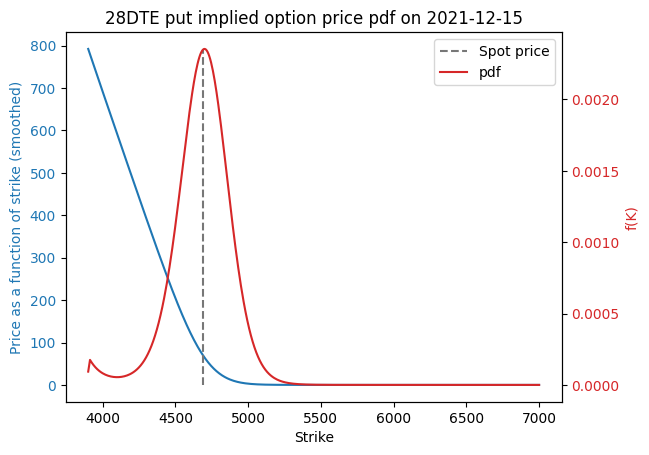

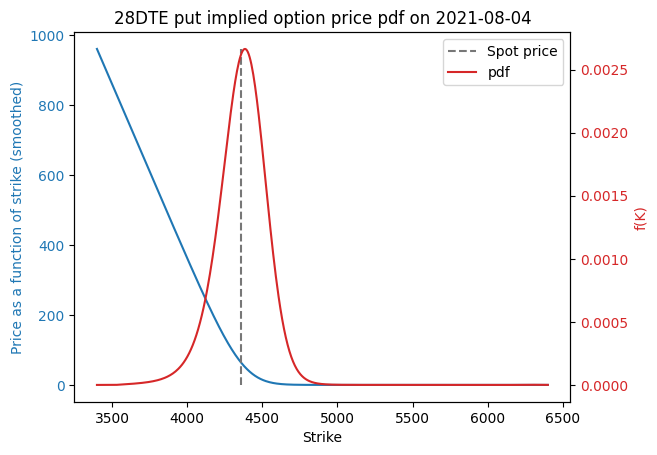

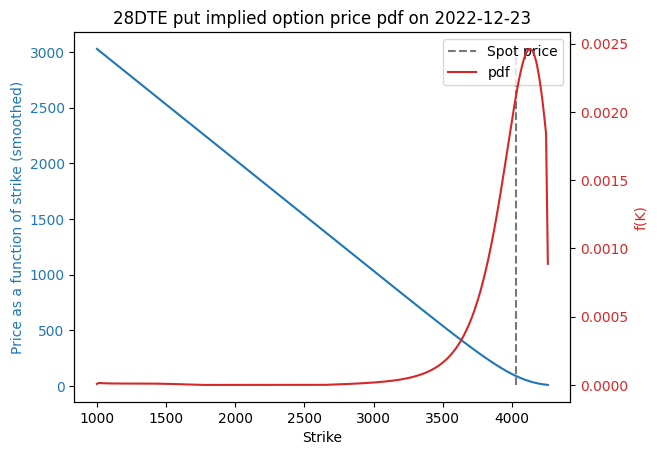

In [6]:
for _ in range(3):
    dfs = {
        "1DTE": spx_1dte_dfs,
        "7DTE": spx_7dte_dfs,
        "28DTE": spx_28dte_dfs,
    }

    df_type = random.choice(["1DTE", "7DTE", "28DTE"])
    df = dfs[df_type][random.randint(0, len(dfs[df_type]))].copy()

    spot_price = df['underlying_last'].mean()   # I am taking the mean just in case, but the underlying_last column should contain only one number

    option_type = ["call", "put"][random.randint(0,1)]

    strike_grid, price_smooth, iv_smooth = smooth_option_curve(
        strikes=df['strike'],
        option_prices=df[f'{option_type}_mid'],
        spot=spot_price,
        T=df['tte_years'].iloc[0],
        option_type="call",
        r=0,
        n_grid=500,
    )
    
    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, 'call')

    fig, ax1 = plt.subplots()

    ax1.plot(strikes_fine, bs_prices_fine)
    ax1.set_xlabel('Strike')
    ax1.set_ylabel('Price as a function of strike (smoothed)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(strikes_fine, f_2(strikes_fine), color='tab:red', label='pdf')
    ax2.set_ylabel('f(K)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    ax1.vlines(x=spot_price, ymin=bs_prices_fine.min(), ymax=bs_prices_fine.max(), color="#777777", linestyles="--", label="Spot price")
    plt.title(f"{df_type} {option_type} implied option price pdf on {pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date()}")
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.show()

## Comparing to market data

Now that I have a way to generate predictions from historical data, I can compare to see what the actual price of the underlying was on the day of expiry.
The method that I'll use to evaluate the accuracy of the predictions is called the **continuous ranked probability score.**
It is defined by
$$ C(D, y) = \int_{\R} (F_D(x) - \mathbf 1_{x \geq y})^2 \, dx, $$
where
- $F_D$ is the cumulative distribution function of the forecasted distribution $D$,
- $\mathbf 1_{x \geq y}$ is the indicator function, which is 1 if $x \geq y$ and 0 otherwise, and
- $y \in \R$ is the observation.

I will evaluate this integral numerically to assign a score to the predicted pdfs.
It is not hard to see by looking at the definition that a lower score is better, with 0 being the lowest possible score, which can only be achieved by the distribution that assigns probability 1 to the observed outcome, and 0 to all other outcomes.
In general, this score rewards some combination of both precision and accuracy.



We'll start by downloading the SPX data for the same range that we have option data.

In [7]:
earliest_day = pd.to_datetime(spx_df['quote_unix'].min(), unit="s")
latest_day = pd.to_datetime(spx_df['expire_unix'].max(), unit="s")

spx_data = yf.download("^SPX", start=earliest_day, end=latest_day, auto_adjust=True)
display(spx_data)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX
Date,,,,,
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000
2020-01-09,3274.699951,3275.580078,3263.669922,3266.030029,3641230000
...,...,...,...,...,...
2024-01-22,4850.430176,4868.410156,4844.049805,4853.419922,4297610000
2024-01-23,4864.600098,4866.479980,4844.370117,4856.799805,3912800000


Now we implement the CRPS function described above, and a function that will calculate the CRPS given a dataframe of option data.

In [8]:

def crps(D_pdf, y, min_input, max_input, n_samples=500):
    """
    Compute the Continuous Ranked Probability Score (CRPS) for a given predictive
    distribution and observation, when D_pdf is a *pdf* on [min_input, max_input].

    Parameters
    ----------
    D_pdf : callable
        Probability density function f(x) of the predictive distribution.
        It must be (approximately) supported on [min_input, max_input].
    y : float
        Observed value.
    min_input : float
        Lower bound of the domain where the pdf is non-negligible.
    max_input : float
        Upper bound of the domain where the pdf is non-negligible.
    n_samples : int, optional
        Number of grid points used for numerical integration.

    Returns
    -------
    float
        Approximate CRPS(F, y).
    """
    # Create a grid on the domain
    z = np.linspace(min_input, max_input, int(n_samples))
    dz = z[1] - z[0]

    # Evaluate the pdf on the grid and clip in case of numerical errors
    f = np.asarray(D_pdf(z), dtype=float)
    f = np.clip(f, 0.0, np.inf)

    # Build the CDF via cumulative sum
    F = np.cumsum(f) * dz
    # Clip for numerical safety so CDF stays in [0, 1]
    F = np.clip(F, 0.0, 1.0)

    # CRPS integral: \int (F(z) - 1_{z >= y})^2 dz
    indicator = (z >= y).astype(float)
    integrand = (F - indicator) ** 2
    crps_val = np.trapezoid(integrand, z)

    return float(crps_val)


def evaluate_rn_option_prediction_from_df(df: pd.DataFrame, option_type):
    """
    Given a dataframe, construct the risk-neutral implied pdf of option prices at the expiry date of the options in the frame.
    Then look up the actual price of SPX at close on the day of expiration and use CRPS to score the prediction.
    """
    
    expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())
    spx_price_on_expiry_date = spx_data.loc[expiry_date, "Close"].iloc[0]

    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, option_type)
    
    return crps(f_2, spx_price_on_expiry_date, strikes_fine.min(), strikes_fine.max())

Before we do the calculation, we can demonstrated a few graphs of pdfs together with the actual value of the underlying at expiration of the options from which we derive the pdf, as well as the CRPS score of the prediction and outcome.

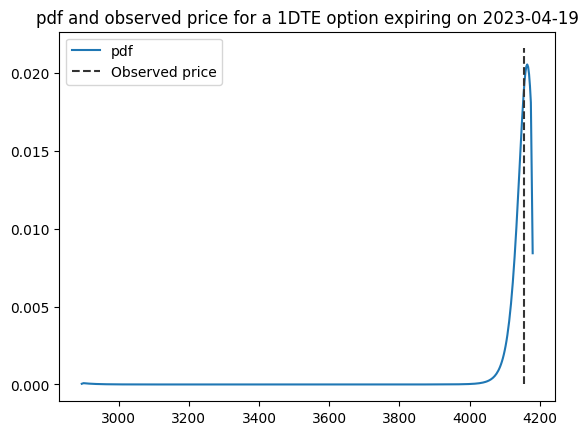

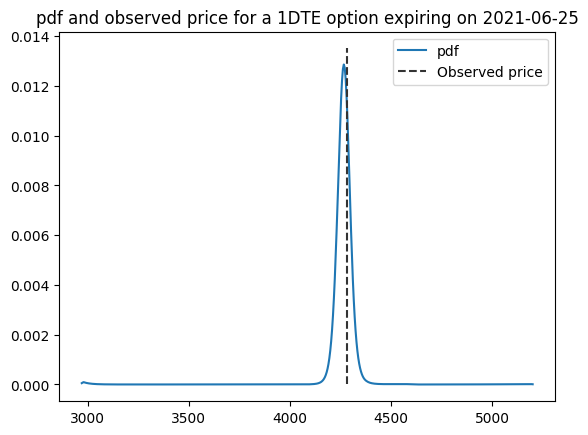

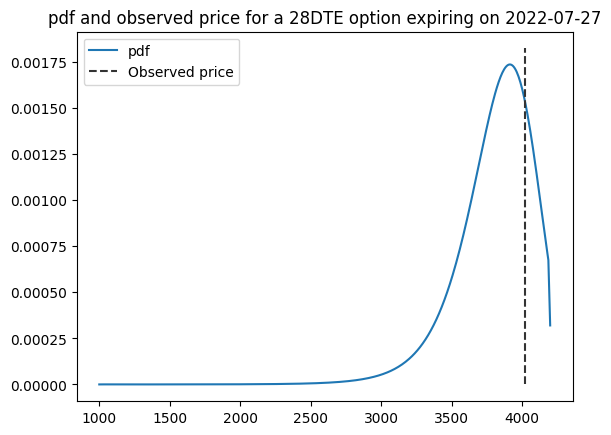

In [9]:
for _ in range(3):
    dfs = {
        "1DTE": spx_1dte_dfs,
        "7DTE": spx_7dte_dfs,
        "28DTE": spx_28dte_dfs,
    }

    df_type = random.choice(["1DTE", "7DTE", "28DTE"])
    df = dfs[df_type][random.randint(0, len(dfs[df_type]))].copy()

    expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())
    spx_price_on_expiry_date = spx_data.loc[expiry_date, "Close"].iloc[0]

    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, option_type)

    plt.plot(strikes_fine, f_2(strikes_fine), label="pdf")
    plt.vlines(spx_price_on_expiry_date, ymin=0, ymax=f_2(strikes_fine).max()*1.05, color="#333333", linestyle="--", label="Observed price")
    plt.title(f"pdf and observed price for a {df_type} option expiring on {expiry_date}")
    plt.legend()
    plt.show()

In [ ]:

print("Calculating CRPS scores...")
for df_type in [spx_1dte_dfs, spx_7dte_dfs, spx_28dte_dfs]:
    c = 0
    p = 0
    for df in df_type:
        
        call_score = evaluate_rn_option_prediction_from_df(df, 'call')
        put_score = evaluate_rn_option_prediction_from_df(df, 'put')
        c += call_score
        p += put_score

    print(f"Average CRPS for {int(df_type[0]['dte'].iloc[0])} DTE calls: {c / len( df_type ) :.2f}")
    print(f"Average CRPS for {int(df_type[0]['dte'].iloc[0])} DTE puts: {p / len( df_type ) :.2f}")


Calculating CRPS scores...
Average CRPS for 1 DTE calls: 28.91
Average CRPS for 1 DTE puts: 26.22


/home/steven/.pyenv/versions/.env/lib/python3.12/site-packages/scipy/interpolate/_fitpack_repro.py:700: RuntimeWarning: error. a theoretically impossible result was found during
the iteration process for finding a smoothing spline with
fp = s. probably causes : s too small.
there is an approximation returned but the corresponding
weighted sum of squared residuals does not satisfy the
condition abs(fp-s)/s < tol.

  _ = root_rati(f, p, bracket, acc)


By themselves these numbers are too abstract to be useful; it isn't clear what constitutes a good or bad score.
We can get some intuition for the meaning of the scores with the following code.
This code calculates the hypothetical scenario in which the stock price at the expiry of the option turns out to be the price that maximizes the density function for the market-implied probability distribution.

We'll also find these numbers useful for comparison in the next section where we test a method of converting the risk-neutral density to real-world density.

In [ ]:
print("Calculating CRPS scores in the hypothetical case that all predictions turn out to be correct...")
for df_type in [spx_1dte_dfs, spx_7dte_dfs, spx_28dte_dfs]:
    s = 0
    for df in df_type:
        expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())

        strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, 'call')
        densities = f_2(strikes_fine)
        max_idx = np.argmax(densities)
        max_probability_price = strikes_fine[max_idx] 
        score = crps(f_2, max_probability_price, strikes_fine.min(), strikes_fine.max())

        s += score                             

    print(f"Average CRPS for {int(df_type[0]['dte'].iloc[0])} DTE calls if all predictions were correct: {s / len( df_type ) :.2f}")

Calculating CRPS scores in the hypothetical case that all predictions turn out to be correct...
Average CRPS for 1 DTE calls if all predictions were correct: 14.42
Average CRPS for 7 DTE calls if all predictions were correct: 30.84


/home/steven/.pyenv/versions/.env/lib/python3.12/site-packages/scipy/interpolate/_fitpack_repro.py:700: RuntimeWarning: error. a theoretically impossible result was found during
the iteration process for finding a smoothing spline with
fp = s. probably causes : s too small.
there is an approximation returned but the corresponding
weighted sum of squared residuals does not satisfy the
condition abs(fp-s)/s < tol.

  _ = root_rati(f, p, bracket, acc)


Average CRPS for 28 DTE calls if all predictions were correct: 65.67


# Part 2: converting the risk-neutral density to a real-world density

See section 16.9 of the book Asset Price Dynamics, Volatility, and Prediction by Stephen Taylor.

As discussed before, the density that we are extracting from the option prices is not just purely the market's prediction of where the stock is likely to move.
So far I have obtained a density $f_Q$ for the risk-neutral probability measure $Q$, and I would like to convert this to a density $f_P$ for the real-world probability measure $P$.
In general there is not an obvious way to do this.

Recall our previous calculation that

\begin{align*}
C(K, T) &= e^{-rT} \mathbb E_Q(\max\{S_T - K, 0\}) \\
&= e^{-rT} \int_0^\infty \max\{x - K, 0\} f_Q(x) \, d x
\end{align*}
We can continue this:
\begin{align*}
\qquad \qquad \qquad \quad &= e^{-rT} \int_0^\infty \max\{x - K, 0\} \frac{f_Q(x)}{f_P(x)} f_P(x) \, dx \\
&= \mathbb E_P[ \max\{S_T - K, 0\} \cdot m(S_T) ],
\end{align*}
where $m(S_T)$ is a random variable called the *stochastic discount factor*, and is defined by the equation above, so that
$$
m(S_T) = e^{-r T} \frac{f_Q(S_T)}{f_P(S_T)}.
$$
Under some assumptions, one can related the stochastic discount factor to the utility function of a representative investor.
One model that has been studient results in the stochastic discount factor being proportional to the representative agent's marginal utility, i.e.
$$m(x) = \lambda \frac{du}{dx},$$
where $u$ is some utility function, and $\lambda$ is a positive constant ($\lambda$ does not matter for the purposes of calculating $f_P$, since we have to normalize).

Bakshi, Kapadia, and Madan (2003), as well as others, use the power utility function for the purpose of obtaining real-world densities from risk-neutral ones, like I'm trying to do here.
This function is defined by
$$
u(x) =
\begin{cases}
\displaystyle \frac{x^{1-\gamma}}{1 - \gamma}, &\gamma \neq 1 \\
\log(x), &\gamma = 1.
\end{cases}
$$
This gives $m(x) \propto x^{-\gamma}$, and so
$$
f_P(x) = \frac{\displaystyle x^\gamma f_Q(x)}{\displaystyle \int_0^\infty y^\gamma f_Q(y) \, dy}.
$$
Below I implement this formula.

In [ ]:
def physical_density_from_rn(fQ, s_min, s_max, n_grid=500, gamma=4):
    """
    Convert a callable risk-neutral pdf fQ(s) into a callable physical pdf fP(s)
    under a CRRA/power-utility assumption with coefficient gamma.

    Parameters
    ----------
    fQ : callable
        Function fQ(s): risk-neutral pdf (should integrate to 1 over its support).
    s_min, s_max : float
        Bounds of the support (integration domain).
    n_grid : int, optional
        Number of grid points used for numerical integration and interpolation (default 500).
    gamma : float, optional
        Coefficient of relative risk aversion (default 4).
        See Taylor's book for some reasons why I chose the value 4.
        (Basically it was calculated previously by some authors
        for S&P 500 options.)

    Returns
    -------
    fP_func : callable
        Function fP(s): normalized physical (real-world) pdf.
    s_grid : ndarray
        Grid used for normalization and interpolation.
    fP_grid : ndarray
        Values of fP(s) on that grid.

    Notes
    -----
    f_P(s) = (s^gamma / E_Q[S_T^gamma]) * f_Q(s)
    
    """
    # evaluate fQ on a grid
    s_grid = np.linspace(s_min, s_max, n_grid)
    fQ_grid = fQ(s_grid)
    fQ_grid = np.clip(fQ_grid, 0, None)  # remove tiny negatives

    # compute E_Q[S_T^gamma]
    Z = np.trapezoid((s_grid ** gamma) * fQ_grid, s_grid)

    fP_grid = (s_grid ** gamma) * fQ_grid / Z

    # normalize
    norm = np.trapezoid(fP_grid, s_grid)
    if norm > 0:
        fP_grid /= norm

    fP_func = CubicSpline(s_grid, fP_grid, extrapolate=False)

    return fP_func, s_grid, fP_grid


def evaluate_physical_option_prediction_from_df(df: pd.DataFrame, option_type):
    """
    Given a dataframe, construct the risk-neutral implied pdf of option prices at the expiry date of the options in the frame.
    Then convert to a physical probability.
    Then look up the actual price of SPX at close on the day of expiration and use CRPS to score the prediction.
    """
 
    expiry_date = str(pd.to_datetime(df['expire_unix'].iloc[0], unit="s").date())
    spx_price_on_expiry_date = spx_data.loc[expiry_date, "Close"].iloc[0]


    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, option_type)
    fP, s_grid, fP_grid = physical_density_from_rn(f_2, strikes_fine.min(), strikes_fine.max())
    
    return crps(fP, spx_price_on_expiry_date, strikes_fine.min(), strikes_fine.max())

Now we'll test this out on options chains from a few different days, to illustrate the difference.

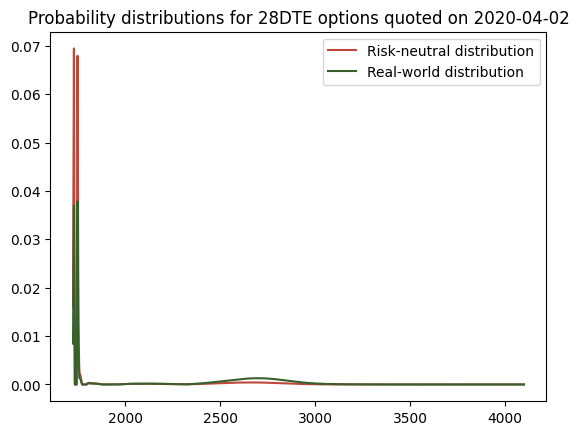

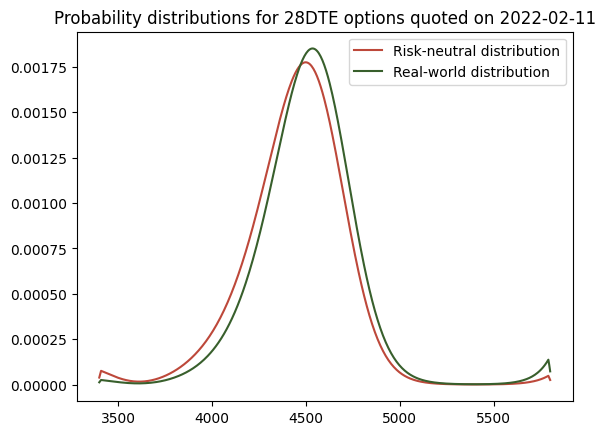

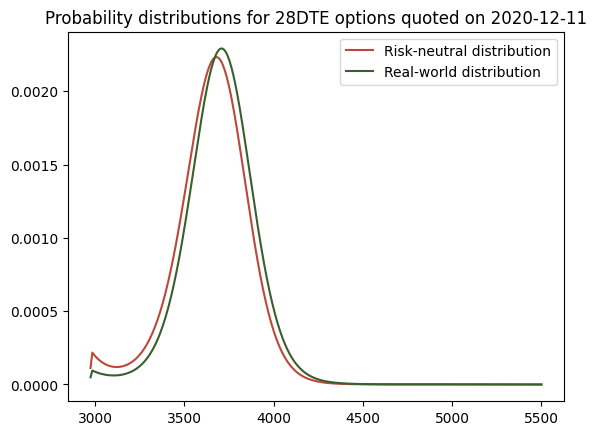

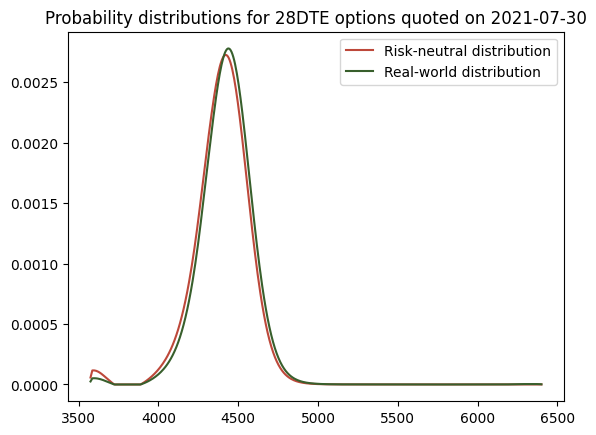

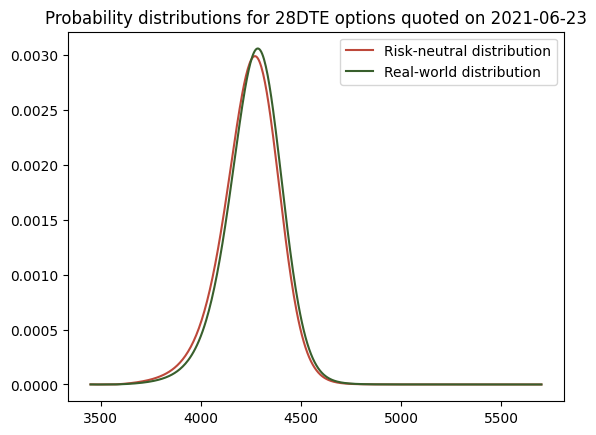

In [ ]:

for _ in range(5):
    df = random.choice(spx_28dte_dfs) # choose a random df
    strikes_fine, bs_prices_fine, f_2 = create_pdf_from_df(df, "call")
    fP, s_grid, fP_grid = physical_density_from_rn(f_2, strikes_fine.min(), strikes_fine.max())
    plt.plot(strikes_fine, f_2(strikes_fine), label="Risk-neutral distribution", color="#BD483A")
    plt.plot(strikes_fine, fP(strikes_fine), label="Real-world distribution", color="#385F2C")
    plt.title(f"Probability distributions for 28DTE options quoted on {pd.to_datetime(df['quote_time'].iloc[0]).date()}")
    plt.legend()
    plt.show()


In [ ]:
print("Starting to calculate CRPS for implied real-world probability distributions...")
for df_type in [spx_1dte_dfs, spx_7dte_dfs, spx_28dte_dfs]:
    c = 0
    p = 0
    for df in df_type:

        c_score = evaluate_physical_option_prediction_from_df(df, 'call')
        p_score = evaluate_physical_option_prediction_from_df(df, 'put')

        c += c_score
        p += p_score

    print(f"Average CRPS for implied physical probability densities of calls with {int(df_type[0]['dte'].iloc[0])} dte: {c / len( df_type )}")
    print(f"Average CRPS for implied physical probability densities of puts with {int(df_type[0]['dte'].iloc[0])} dte: {p / len( df_type )}")

print("Done.")

Starting to calculate CRPS for implied real-world probability distributions...
Average CRPS for implied physical probability densities of calls with 1 dte: 28.20287968415728
Average CRPS for implied physical probability densities of puts with 1 dte: 26.964533277623747


KeyboardInterrupt: 

# Conclusion

In this project I explored a numerical method to compute risk-neutral probability distributions of underlying assets from option prices.
This part involved interpolating and smoothing a price curve for the options across different strikes by converting to implied volatility as a function of log-moneyness.
This part could probably be improved by using a parametric model designed for volatility smiles.
Through all the interpolation and conversion between different spaces and numeric differentiation, this process ended up being rather slow; I think this would be the first place I might focus for improvement.

In the second part of the project I compared the predictions to real performance of the asset.
I did this using the continuous ranked probability score, which I think is appropriate for this setting, but the outputs that it produced could use some more context, to give a better understanding of their meaning.

Finally I tested a method of converting the risk-neutral probability distribution into a real-world one.
I discovered that, based on the CRPS, the converted distribution was in fact better at predicting movements of stocks than the risk-neutral one, as hoped.
That being said, during this stage of the project I had to rely heavily on existing literature and didn't have the chance to figure things out for myself.
After performance and efficiency adjustments, the next thing I would do to build on this project is to find a better way to construct the real-world probability distribution from the risk-neutral one.

I used ChatGPT to generate docstrings for of the functions above.

# References and further reading

Here I have collected some sources of information for this project, as well as some interesting resources related to the topics discussed.

### **Market-implied probabilities**

[Are market implied probabilities useful?](https://blog.thinknewfound.com/2017/11/market-implied-probabilities-useful/) - A blog post.

[A blog post titled "Options Implied Distributions are NOT Real-World Distributions"](https://freeportlogbook.substack.com/p/options-implied-distributions-are) - A blog post.

### **Estimating real-world probabilities from option-implied risk-neutral probabilities**

[Understanding the Connection between Real-World and Risk-Neutral Scenario Generators.](https://www.soa.org/4ab88e/globalassets/assets/files/resources/research-report/2022/understanding-the-connection.pdf) - an SOA Research Institute article.

[Steve Ross: The Recovery Theorem.](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.12092) - A theorem about recovering the real-world probability distribution from the market-implied one.

[Does the Ross recovery theorem work empirically?](https://www.sciencedirect.com/science/article/abs/pii/S0304405X20300763) - An article that gives some evidence that the Ross recovery theorem may break down in the real world.

[Estimating the real-world density from the option-implied risk-neutral density.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2093397) - A paper.

[Quant stackexchange.](https://quant.stackexchange.com/questions/50700/what-is-the-connection-between-the-risk-neutral-implied-density-and-the-real-wor/50701#50701) - A post about estimating the implied real-world density from option prices.


[Bakshi, Kapadia, and Madan (2003) risk-neutral moment estimators: A Gram–Charlier density approach](https://link.springer.com/article/10.1007/s11147-022-09187-x)

### **Other topics**

[Wikipedia article on scoring rules](https://en.wikipedia.org/wiki/Scoring_rule).
These are rules that are used to assign a score to a predicted probability distribution and an observed value; exactly what we are doing to compare the risk-neutral distributions to real market movements.


[Stephen Taylor: Asset Prices Dynamics, Volatility, and Prediction.](https://ia801604.us.archive.org/20/items/quant_books/Asset%20Price%20Dynamics%2C%20Volatility%20_%20Prediction%20-%20S.%20J.%20Taylor.pdf) - A really good book about a lot of different topics related to this project.
In particular see chapter 16: Density Prediction for Asset Prices, and section 16.9: From Risk-Neutral to Real-World Densities